In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.9.7.29-1+cuda12.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Need to get 885 MB of archives.
After this operation, 56.3 kB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8-dev 8.9.7.29-1+cuda12.2 [440 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8 8.9.7.29-1+cuda12.2 [444 MB]
Fetched 885 MB in 20s (44.3 MB/s)
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../libcudnn8-dev_8.9.7.29-1+cuda12.2_amd64.deb ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
Unpacking libcudnn8-dev (8

In [ ]:
# NOTE (05/11/2022) - The default URL for downloading the dataset via TFDS is currently invalid. This piece of code
# will patch that URL with the correct one. Please run this before importing the packages. If it fails, kindly report
# in our Discourse community. Thank you!

DATASET_PATH = '/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py'
!sed -i 's/3367a/5340/g' {DATASET_PATH}

sed: can't read /usr/local/lib/python3.7/dist-packages/tensorflow_datasets/image_classification/cats_vs_dogs.py: No such file or directory


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [ ]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

In [ ]:
dataset,info = tfds.load('cats_vs_dogs', with_info = True, as_supervised=True)
print(info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, 

In [ ]:
def preprocess(image,label):
    # Extract image and species label
    # Adjust if the key is different
    label = tf.one_hot(label, depth=2)


    return image, label

# Apply the preprocessing function to your dataset
train_data = train_data.map(preprocess)
validation_data = validation_data.map(preprocess)
test_data = test_data.map(preprocess)


In [ ]:
def augment_images(image, label):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)
augmented_validation_data = validation_data.map(augment_images)
validation_batches = augmented_validation_data.batch(32)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input

# Define a new input layer that matches the shape you want
new_input = Input(shape=(300, 300, 3))  # Adjust the shape as needed

# Load VGG16 pre-trained model without the top layer (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3),input_tensor=new_input)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of VGG16
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14715714 (56.14 MB)
Trainable params: 1026 (4.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_batches, epochs=10, validation_data=validation_batches)  # Reduced epochs due to pre-trained nature

Epoch 1/10
582/582 [==============================] - 199s 317ms/step - loss: 0.4523 - accuracy: 0.8323 - val_loss: 0.3438 - val_accuracy: 0.8822
Epoch 2/10
582/582 [==============================] - 172s 293ms/step - loss: 0.3046 - accuracy: 0.8969 - val_loss: 0.2783 - val_accuracy: 0.8951
Epoch 3/10
582/582 [==============================] - 175s 297ms/step - loss: 0.2590 - accuracy: 0.9074 - val_loss: 0.2467 - val_accuracy: 0.9033
Epoch 4/10
582/582 [==============================] - 172s 292ms/step - loss: 0.2345 - accuracy: 0.9135 - val_loss: 0.2277 - val_accuracy: 0.9119
Epoch 5/10
582/582 [==============================] - 174s 296ms/step - loss: 0.2187 - accuracy: 0.9193 - val_loss: 0.2159 - val_accuracy: 0.9132
Epoch 6/10
582/582 [==============================] - 173s 295ms/step - loss: 0.2068 - accuracy: 0.9228 - val_loss: 0.2046 - val_accuracy: 0.9179
Epoch 7/10
582/582 [==============================] - 172s 292ms/step - loss: 0.1987 - accuracy: 0.9252 - val_loss: 0.1988 -

In [ ]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [ ]:
print(model.input)
print(model.layers[0])
print(model.layers[-3].output)
print(model.layers[-1].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='vgg16_input'), name='vgg16_input', description="created by layer 'vgg16_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

x = GlobalAveragePooling2D()(base_model.output)
output = Dense(2, activation='softmax')(x)

# Create the new CAM model
cam_model = Model(inputs=new_input, outputs=[base_model.get_layer('block5_conv3').output, output])

current_weights, current_biases = cam_model.layers[-1].get_weights()

# Assign gap_weights to the weights part, keeping biases the same
cam_model.layers[-1].set_weights([gap_weights, current_biases])
# Redefine the CAM model using the correct layer outputs
"""cam_model = Model(inputs=base_model.get_layer('block1_conv1').input,
                  outputs=(base_model.get_layers[-3].output,model.layers[-1].output))
"""
# Print summary to check the setup
cam_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [ ]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]

  prediction =  np.argmax(results[0])


  class_labels = ['Cat', 'Dog']
  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,np.argmax(results[0])]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/18, 300/18, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  predicted_class = class_labels[prediction]
  # visualize the results
  print(f'softmax output: {results}')
  print(f"prediction class: {predicted_class}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


In [ ]:
!wget -O cat1.jpg https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg
!wget -O cat2.jpg https://i.natgeofe.com/n/9135ca87-0115-4a22-8caf-d1bdef97a814/75552.jpg
!wget -O catanddog.jpg https://www.telegraph.co.uk/content/dam/news/2023/06/10/TELEMMGLPICT000296384999_16864028803870_trans_NvBQzQNjv4BqrCS9JVgwgb8GODK1xmD4xlHwtdpQwyNje2OyIL7x97s.jpeg
!wget -O dog1.jpg https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg
!wget -O dog2.jpg https://www.hindustantimes.com/ht-img/img/2023/08/25/1600x900/international_dog_day_1692974397743_1692974414085.jpg

--2023-12-28 15:20:38--  https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg
Resolving www.alleycat.org (www.alleycat.org)... 141.193.213.20, 141.193.213.21
Connecting to www.alleycat.org (www.alleycat.org)|141.193.213.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107329 (105K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 104.81K  --.-KB/s    in 0.009s  

2023-12-28 15:20:38 (11.8 MB/s) - ‘cat1.jpg’ saved [107329/107329]

--2023-12-28 15:20:38--  https://i.natgeofe.com/n/9135ca87-0115-4a22-8caf-d1bdef97a814/75552.jpg
Resolving i.natgeofe.com (i.natgeofe.com)... 23.216.147.40, 23.216.147.15, 2600:1406:4c00::1701:ed99, ...
Connecting to i.natgeofe.com (i.natgeofe.com)|23.216.147.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060932 (1.0M) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jpg            100%[===================>]   1.01M  --.-KB/s    in 0.04s   

2023-12-28 15:20:38 (28

1/1 [==============================] - 2s 2s/step
softmax output: [[9.9997437e-01 2.5611023e-05]]
prediction class: Cat


1/1 [==============================] - 0s 32ms/step
softmax output: [[9.9997056e-01 2.9431030e-05]]
prediction class: Cat


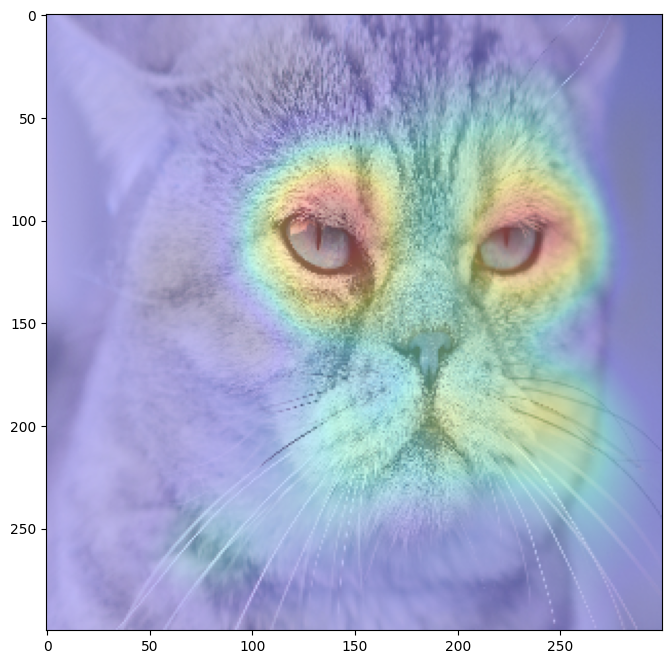

1/1 [==============================] - 0s 18ms/step
softmax output: [[0.00920501 0.99079496]]
prediction class: Dog


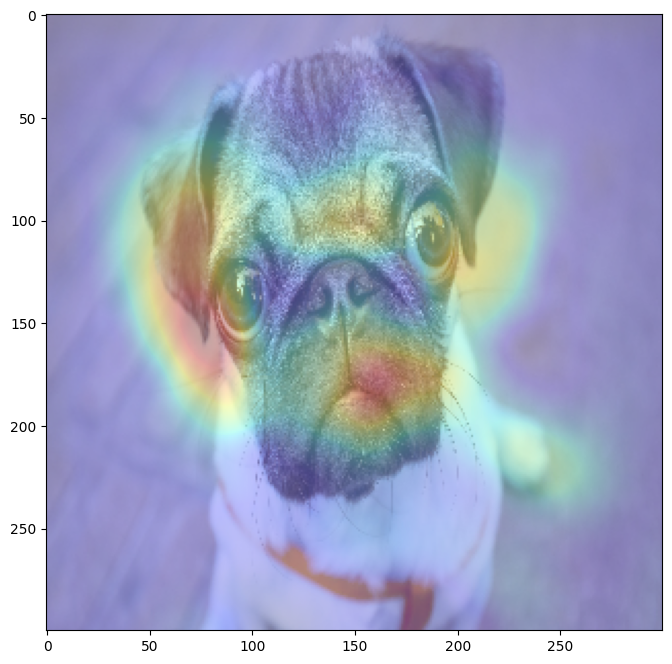

1/1 [==============================] - 0s 39ms/step
softmax output: [[4.340939e-04 9.995659e-01]]
prediction class: Dog


1/1 [==============================] - 0s 25ms/step
softmax output: [[9.7145530e-06 9.9999034e-01]]
prediction class: Dog


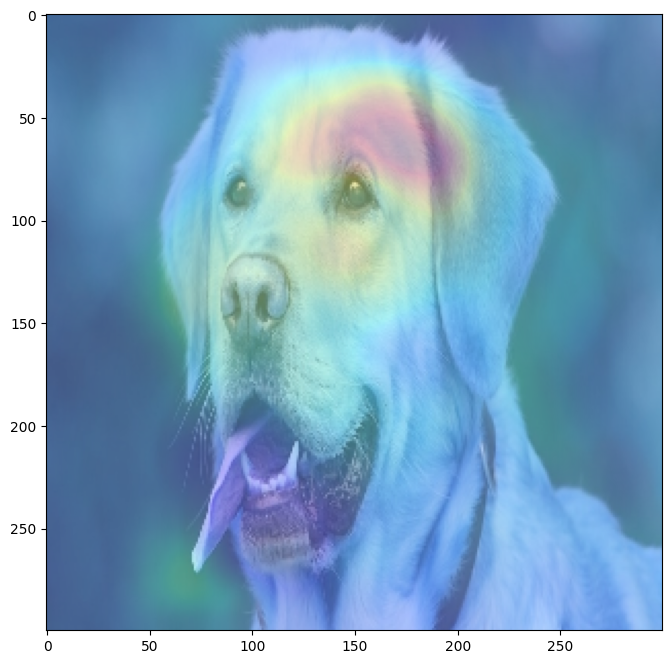

In [ ]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
1/1 [==============================] - 0s 18ms/step
softmax output: [[9.9928623e-01 7.1376574e-04]]
prediction class: Cat


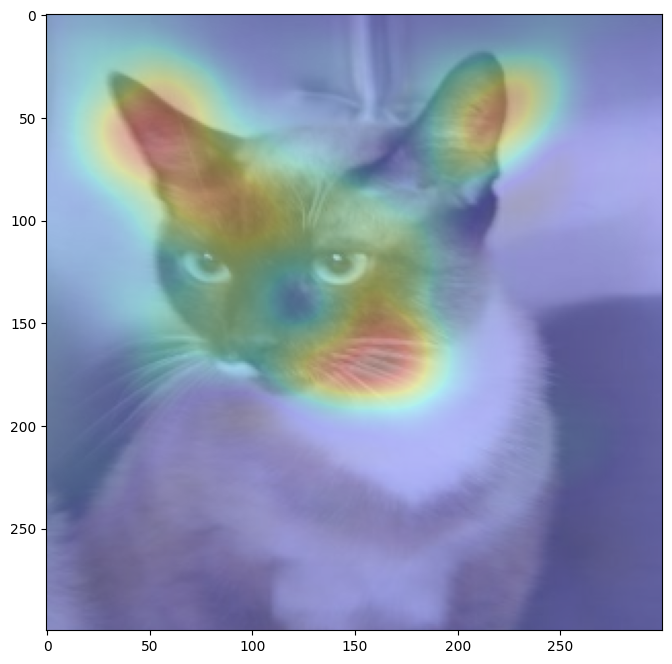

ground truth: dog
1/1 [==============================] - 0s 18ms/step
softmax output: [[0.81405437 0.18594566]]
prediction class: Cat


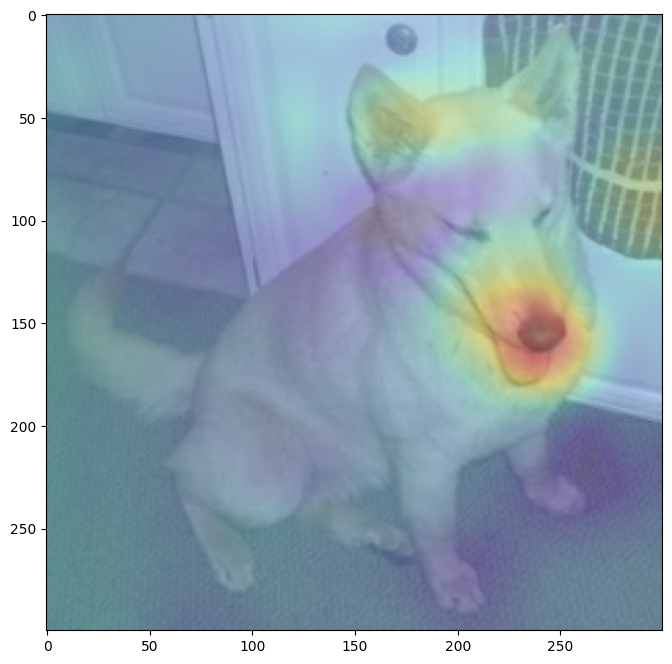

ground truth: dog
1/1 [==============================] - 0s 38ms/step
softmax output: [[0.28170255 0.7182974 ]]
prediction class: Dog


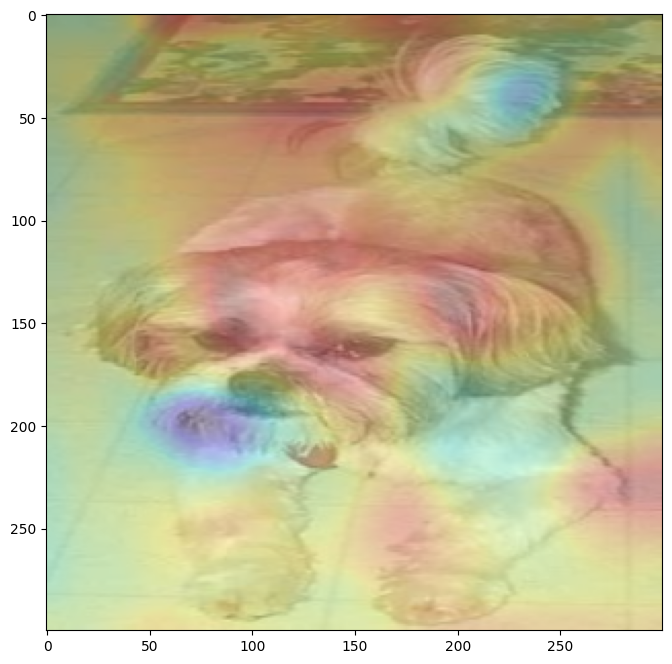

ground truth: cat
1/1 [==============================] - 0s 25ms/step
softmax output: [[9.99987602e-01 1.23628015e-05]]
prediction class: Cat


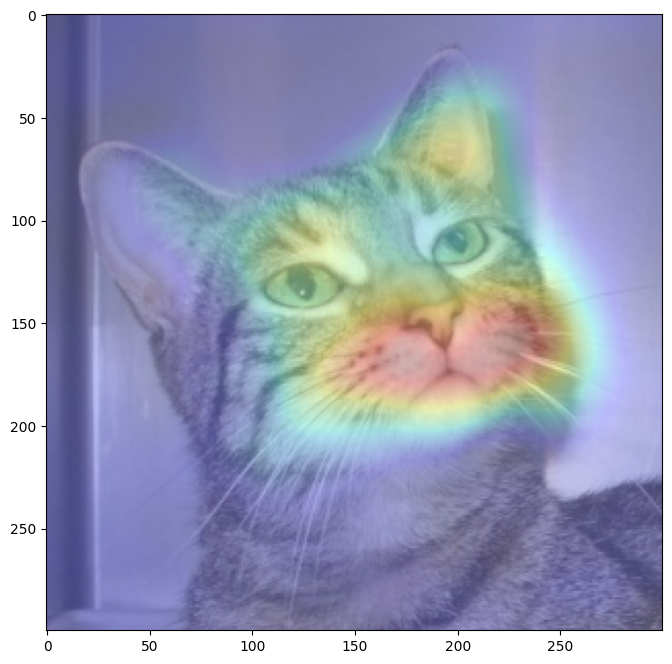

ground truth: cat
1/1 [==============================] - 0s 35ms/step
softmax output: [[0.9963265 0.0036735]]
prediction class: Cat


In [ ]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)

for img, lbl in test_batches.take(5):
    # Convert lbl tensor to numpy and use the first element for condition
    lbl_np = lbl.numpy()
    ground_truth = 'cat' if lbl_np[0][0] == 1 else 'dog'  # Adjust depending on how your labels are encoded

    print(f"ground truth: {ground_truth}")
    features, results = cam_model.predict(img)
    show_cam(img, features, results)